In [1]:
import isabl_cli as ii
import pandas as pd
from pandas.io.json import json_normalize

In [2]:
pilot_samples = [
    # Batch Week 1
    "IID_H200642_T01_01_WG01",
    "IID_H200643_T01_01_WG01",
    "IID_H200644_T01_01_WG01",
    "IID_H200645_T01_01_WG01",
    # Batch Week 2
    "IID_H158273_T12_01_WG02",
    "IID_H200646_T01_01_WG01",
    "IID_H200647_T01_01_WG02",
    "IID_H200648_T01_01_WG01",
    # Batch Week 3
    "IID_H201277_T01_01_WG01",
    "IID_H201278_T01_01_WG01",
    "IID_H201279_T01_01_WG01",
    "IID_H201280_T01_01_WG01",
    # Batch Week 4
    "IID_H198661_T02_01_WG01",
    "IID_H201471_T01_01_WG01",
    "IID_H201472_T01_01_WG01",
    "IID_H201473_T02_01_WG01",
]

filters = {
    'projects': 267, 
    'sample__category': 'TUMOR',
    'system_id__in': pilot_samples
}
exps = ii.get_experiments(**filters)

Retrieving 16 from experiments API endpoint...


In [3]:
def get_coverage(analyses):
    try:
        return [
            r_url 
            for a in ans 
            if a.application.name == 'MOSDEPTH' 
            for r_key, r_url in a.results.items() 
            if r_key == 'median_coverage'
        ][0]
    except:
        raise 'No Coverage Result was found'

df = pd.DataFrame()
for e in exps[:]:
    filters = {
        'application.name.contains!': 'QC_DATA',
        'application.name!': 'MSK_KIDS_REPORT',
        'application.pk!': 97,
        'status': 'SUCCEEDED'
    }
    ans = ii.get_analyses(targets__system_id=e.system_id, **filters)
    cols = [
        "application.name", 
        "pk", 
        "status", 
        "run_time", 
        "storage_usage", 
        "started", 
        "finished",
        "created"
    ]
    df_e = json_normalize(ans)[cols]
    df_e['system_id'] = e.system_id
    df_e['identifier'] = e.identifier
    df_e['coverage'] = get_coverage(ans)
    df_e['rsystem_id'] = df_e['system_id'].where(df_e['system_id'] != df_e['system_id'].shift(), '')
    df_e['started'] = df_e.apply(lambda x: x['created'] if x['application.name'] == 'BATTENBERG' else x['started'], axis=1)
    df_e['min_started'] = df_e['started'].min()
    df = df.append(df_e[::-1], ignore_index=True)


Retrieving 17 from analyses API endpoint...
Retrieving 17 from analyses API endpoint...
Retrieving 17 from analyses API endpoint...
Retrieving 17 from analyses API endpoint...
Retrieving 17 from analyses API endpoint...
Retrieving 16 from analyses API endpoint...
Retrieving 17 from analyses API endpoint...
Retrieving 17 from analyses API endpoint...
Retrieving 17 from analyses API endpoint...
Retrieving 15 from analyses API endpoint...
Retrieving 17 from analyses API endpoint...
Retrieving 17 from analyses API endpoint...
Retrieving 17 from analyses API endpoint...
Retrieving 17 from analyses API endpoint...
Retrieving 17 from analyses API endpoint...
Retrieving 17 from analyses API endpoint...


In [4]:
from matplotlib.dates import DateFormatter, HourLocator
import matplotlib.pyplot as plt
from dateutil import parser
import numpy as np
from io import StringIO
import datetime as dt
import math 

%matplotlib inline

data = df[::-1]

def name_duration(row):
    app_name = row['application.name']
    duration = parser.isoparse(row['finished']) - parser.isoparse(row['started'])
    duration_str = " hours ".join(str(duration).split(':')[:2])
    
    if app_name == "BWA_MEM" and duration < dt.timedelta(hours=4):
        app_name = "*" + app_name
    return f'{app_name} ({duration_str} min)'

cap = data.apply(name_duration, axis=1)
start = data['started'].apply(parser.isoparse)
stop = data['finished'].apply(parser.isoparse)


In [5]:
def get_duration(row):
    duration = parser.isoparse(row['finished']) - parser.isoparse(row['started'])
    return round(duration.total_seconds() / 3600, 2)

data.loc[:, 'duration'] = data.apply(get_duration, axis=1)
data.loc[:, 'initial'] = 0
data.loc[:, 'start_offset'] = 0

/juno/work/isabl/opt/python/.virtualenvs/users/arangooj/jupyter/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/juno/work/isabl/opt/python/.virtualenvs/users/arangooj/jupyter/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
import json
import os

# Remove waiting time for 1 outlier Battenberg job that had cluster issues and was ran 5 days later
battenbergs_to_fix = ['IID_H200646_T01_01_WG01']

for sid in battenbergs_to_fix:
    
    # Remove waiting time 
    to_fix_sid = sid
    bbg = ii.get_analyses(targets__system_id=to_fix_sid, application__name="BATTENBERG")[0]
    outdir = bbg['storage_url']

    # Parse real runtimes from stats files
    real_runtime = 0
    for step in {"subclones", "forcecn", "refitcn", "finalise"}:
        step_stats = f'{outdir}/stats_toil.{step}.json'
        if os.path.isfile(step_stats):
            with open(step_stats, 'rt') as stats:
                t = json.loads(stats.read())['total_run_time'] / 3600
                real_runtime += t
                print(step, t)
            
    print('Total Battenberg', real_runtime)
    absolute_runtime = data.loc[(data['system_id'] == to_fix_sid) & (data['application.name'] == 'BATTENBERG'), 'duration']
    print('Old Battenberg', real_runtime)

    # Substract dead time to downstream apps after battenberg
    bbg_dead_time = int(data[(data['system_id'] == to_fix_sid) & (data['application.name'] == 'BATTENBERG')]['duration'] - real_runtime)
    data.loc[(data['system_id'] == to_fix_sid) & (data['application.name'] == 'BATTENBERG'), 'duration'] = real_runtime
    
    apps_after_bbg = ['BRASS', 'CAVEMAN', 'ANNOT_SNVS', 'ANNOT_SVS', 'WGSPOST', 'CLONALITY']
    data.loc[(data['system_id'] == to_fix_sid) & (data['application.name'].isin(apps_after_bbg)), 'start_offset'] = bbg_dead_time

    data[data['system_id'] == to_fix_sid]

Retrieving 1 from analyses API endpoint...


finalise 0.5512221564194445
forcecn 1.5704256872333333
subclones 9.719126996666667
Total Battenberg 11.840774840319444
Old Battenberg 11.840774840319444


In [7]:
def get_relative_start(row):
    app_name = row['application.name']
    relative_start = parser.isoparse(row['started']) - parser.isoparse(row['min_started']) 
    return round(relative_start.total_seconds() / 3600 - row['start_offset'], 2)

def get_relative_duration(row):
    return row['relative_start'] + row['duration']

duration = data['duration']
initial = data['initial']

data.loc[:, 'relative_start'] = data.apply(get_relative_start, axis=1)
data.loc[:, 'relative_duration'] = data.apply(get_relative_duration, axis=1)
rstart = data['relative_start']
rduration = data['relative_duration']

In [8]:
data.head()

,application.name,pk,status,run_time,storage_usage,started,finished,created,system_id,identifier,coverage,rsystem_id,min_started,duration,initial,start_offset,relative_start,relative_duration
268,BWA_MEM,403387,SUCCEEDED,2213.031133,150166236320,2021-01-20T11:57:30.785380-05:00,2021-01-22T00:50:32.653386-05:00,2021-01-20T10:25:48.126919-05:00,IID_H201473_T02_01_WG01,XPRO_0385_T2_DNA_IGO_08822_IO_4,102,IID_H201473_T02_01_WG01,2021-01-20T11:57:30.785380-05:00,36.88,0,0,0.00,36.88
267,MOSDEPTH,403771,SUCCEEDED,34.393412,50529916,2021-01-22T02:03:46.520839-05:00,2021-01-22T02:38:10.125579-05:00,2021-01-22T00:50:35.206460-05:00,IID_H201473_T02_01_WG01,XPRO_0385_T2_DNA_IGO_08822_IO_4,102,,2021-01-20T11:57:30.785380-05:00,0.57,0,0,38.10,38.67
266,BATTENBERG,403772,SUCCEEDED,26.426232,4074628132,2021-01-22T00:50:43.994214-05:00,2021-01-25T10:40:47.858579-05:00,2021-01-22T00:50:43.994214-05:00,IID_H201473_T02_01_WG01,XPRO_0385_T2_DNA_IGO_08822_IO_4,102,,2021-01-20T11:57:30.785380-05:00,81.83,0,0,36.89,118.72
265,CONPAIR,403773,SUCCEEDED,52.847282,68538953,2021-01-22T00:50:58.682172-05:00,2021-01-22T01:43:49.519120-05:00,2021-01-22T00:50:45.371235-05:00,IID_H201473_T02_01_WG01,XPRO_0385_T2_DNA_IGO_08822_IO_4,102,,2021-01-20T11:57:30.785380-05:00,0.88,0,0,36.89,37.77
264,GRIDSS,403774,SUCCEEDED,962.219404,5691483585,2021-01-22T02:55:38.617319-05:00,2021-01-22T18:57:51.781589-05:00,2021-01-22T00:50:46.750647-05:00,IID_H201473_T02_01_WG01,XPRO_0385_T2_DNA_IGO_08822_IO_4,102,,2021-01-20T11:57:30.785380-05:00,16.04,0,0,38.97,55.01


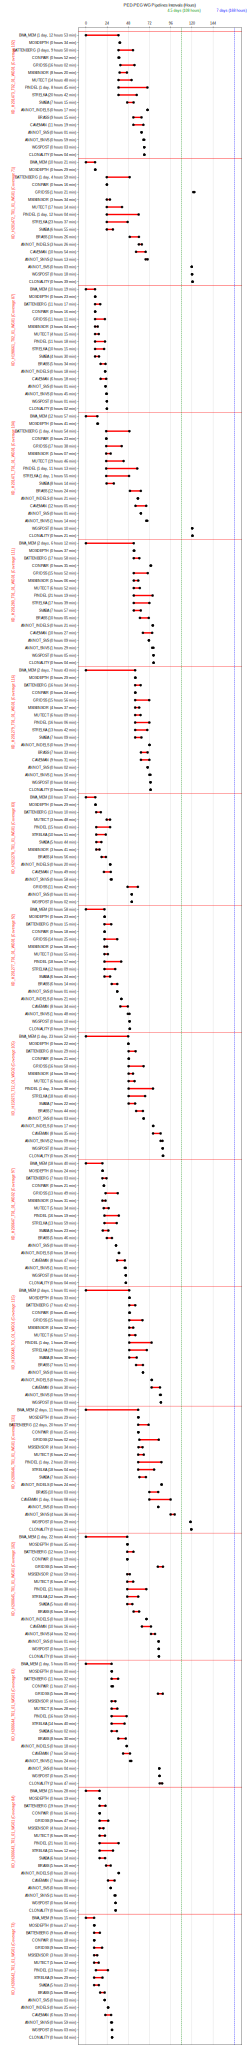

In [25]:
plt.figure(figsize=(10, math.floor(len(data) * 0.3)))
plt.errorbar(rstart, np.arange(len(data)), xerr=[np.zeros(len(data)), duration], ms=12, fmt='.k', ecolor='red', lw=4, uplims=True, lolims=True)
plt.errorbar(rduration, np.arange(len(data)), xerr=[np.zeros(len(data)), np.zeros(len(data))], ms=12, fmt='.k', ecolor='red', lw=4, uplims=True, lolims=True)

ax = plt.gca()
_ = plt.yticks(np.arange(len(data)), cap)
_ = ax.xaxis.set_label_position('top') 
_ = ax.xaxis.tick_top()
_ = ax.set_xticks(np.arange(0, 24*7, 24))
_ = ax.grid(which='major', axis='x', linestyle='-', color="#cccccc")
_ = ax.set_ylim(len(data), -1)
_ = ax.set_title('PED-PEG WG Pipelines Intervals (Hours)', y=1.0, pad=60)

# Divide by Experiments
max_x = rduration.max()
for index in data[data['rsystem_id'] != ''].index:
    y_index = len(data) - 1 - index
    label = f"{data['system_id'][index]} (Coverage {data['coverage'][index]})"
    
    # _ = ax.get_yticklabels()[y_index].set_color("red")
    _ = ax.axhline(y=y_index - 0.5, linewidth=1, linestyle='-',color='r')
    _ = ax.text(
        # 24*7 - 2 , y_index, 
        - 80, y_index,
        label,
        verticalalignment='top', 
        horizontalalignment='right',
        color='red',
        rotation=90
    )

# threshold
days = 7
_ = ax.axvline(x= 24 * days, linewidth=1, linestyle='--',color='blue')
_ = ax.text(24 * days - 3, -3.5, f'{days} days ({days * 24} hours)', verticalalignment='top', horizontalalignment='center', color='blue')

days = 4.5
_ = ax.axvline(x= 24 * days, linewidth=1, linestyle='--',color='green')
_ = ax.text(24 * days + 3, -3.5, f'{days} days ({int(days * 24)} hours)', verticalalignment='top', horizontalalignment='center', color='green')


from io import BytesIO
from IPython.display import SVG, display

def display_svg(filename=None,font="Arial"):
    plt.rcParams['svg.fonttype'] = 'none'
    svg = BytesIO()
    plt.tight_layout()
    plt.savefig(svg, format="svg",bbox_inches = 'tight')
    if filename:
        plt.savefig(filename, format="svg",bbox_inches = 'tight')
    plt.close()
    svg.seek(0)
    display(SVG(svg.read().decode("utf-8").replace("font-family:DejaVu Sans",f"font-family:{font}")))

filename = "PedPegPilot-NoWaits"
plt.savefig(f"{filename}.pdf", bbox_inches='tight')    
display_svg(f"{filename}.svg")

In [26]:
data.head()

,application.name,pk,status,run_time,storage_usage,started,finished,created,system_id,identifier,coverage,rsystem_id,min_started,duration,initial,start_offset,relative_start,relative_duration
268,BWA_MEM,403387,SUCCEEDED,2213.031133,150166236320,2021-01-20T11:57:30.785380-05:00,2021-01-22T00:50:32.653386-05:00,2021-01-20T10:25:48.126919-05:00,IID_H201473_T02_01_WG01,XPRO_0385_T2_DNA_IGO_08822_IO_4,102,IID_H201473_T02_01_WG01,2021-01-20T11:57:30.785380-05:00,36.880000,0,0,0.00,36.880000
267,MOSDEPTH,403771,SUCCEEDED,34.393412,50529916,2021-01-22T02:03:46.520839-05:00,2021-01-22T02:38:10.125579-05:00,2021-01-22T00:50:35.206460-05:00,IID_H201473_T02_01_WG01,XPRO_0385_T2_DNA_IGO_08822_IO_4,102,,2021-01-20T11:57:30.785380-05:00,0.570000,0,0,38.10,38.670000
266,BATTENBERG,403772,SUCCEEDED,26.426232,4074628132,2021-01-22T00:50:43.994214-05:00,2021-01-25T10:40:47.858579-05:00,2021-01-22T00:50:43.994214-05:00,IID_H201473_T02_01_WG01,XPRO_0385_T2_DNA_IGO_08822_IO_4,102,,2021-01-20T11:57:30.785380-05:00,16.455423,0,0,36.89,53.345423
265,CONPAIR,403773,SUCCEEDED,52.847282,68538953,2021-01-22T00:50:58.682172-05:00,2021-01-22T01:43:49.519120-05:00,2021-01-22T00:50:45.371235-05:00,IID_H201473_T02_01_WG01,XPRO_0385_T2_DNA_IGO_08822_IO_4,102,,2021-01-20T11:57:30.785380-05:00,0.880000,0,0,36.89,37.770000
264,GRIDSS,403774,SUCCEEDED,962.219404,5691483585,2021-01-22T02:55:38.617319-05:00,2021-01-22T18:57:51.781589-05:00,2021-01-22T00:50:46.750647-05:00,IID_H201473_T02_01_WG01,XPRO_0385_T2_DNA_IGO_08822_IO_4,102,,2021-01-20T11:57:30.785380-05:00,16.040000,0,0,38.97,55.010000


In [27]:
# !pip install python-dotenv

# Query IGO timelines from LIMS
import os
import requests
import json
import urllib3
import pandas as pd
import numpy as np
from datetime import datetime

from requests.auth import HTTPBasicAuth
from dotenv import load_dotenv

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
load_dotenv()

IGO_USERNAME = os.environ.get("IGO_USERNAME")
IGO_PWD = os.environ.get("IGO_PWD")

cookies = {'jic': 'eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJfaWQiOiI1ZmM4MDI3OTZiZmFjZDJjNTY5YTJjYTAiLCJmaXJzdE5hbWUiOiJKdWFuIiwibGFzdE5hbWUiOiJBcmFuZ28gT3NzYSIsInVzZXJuYW1lIjoiYXJhbmdvb2oiLCJ0aXRsZSI6IkJpb2luZm8uRW5nci5JSUkiLCJpc0xhYk1lbWJlciI6ZmFsc2UsImlzQWRtaW4iOmZhbHNlLCJpc1BNIjpmYWxzZSwiaXNVc2VyIjp0cnVlLCJsb2dpbkxhc3REYXRlIjoiMjAyMS0wMS0yNVQyMjo1MzoxMi42MTVaIiwiaGllcmFyY2h5IjpbeyJkbiI6IkNOPWFyYW5nb29qLE9VPVNsb2FuIEtldHRlcmluZyBJbnN0aXR1dGUsT1U9U0tJLERDPU1TS0NDLERDPVJPT1QsREM9TVNLQ0MsREM9T1JHIiwiY29udHJvbHMiOltdLCJjbiI6ImFyYW5nb29qIiwic24iOiJBcmFuZ28gT3NzYSIsInRpdGxlIjoiQmlvaW5mby5FbmdyLklJSSIsImdpdmVuTmFtZSI6Ikp1YW4iLCJkaXNwbGF5TmFtZSI6IkFyYW5nbyBPc3NhLCBKdWFuIEUuL1Nsb2FuIEtldHRlcmluZyBJbnN0aXR1dGUiLCJzQU1BY2NvdW50TmFtZSI6ImFyYW5nb29qIn0seyJkbiI6IkNOPXBhcGFlbW1lLE9VPUVwaWRlbWlvbG9neS1CaW9zdGF0aXN0aWNzLE9VPU1FTSxEQz1NU0tDQyxEQz1ST09ULERDPU1TS0NDLERDPU9SRyIsImNvbnRyb2xzIjpbXSwiY24iOiJwYXBhZW1tZSIsInNuIjoiUGFwYWVtbWFudWlsIiwidGl0bGUiOiJBc3Npc3RhbnQgQXR0ZW5kaW5nIiwiZ2l2ZW5OYW1lIjoiRWxsaSIsImRpc3BsYXlOYW1lIjoiUGFwYWVtbWFudWlsLCBFbGxpL0VwaWRlbWlvbG9neS1CaW9zdGF0aXN0aWNzIiwic0FNQWNjb3VudE5hbWUiOiJwYXBhZW1tZSJ9LHsiZG4iOiJDTj1zaGFoczMsT1U9RXBpZGVtaW9sb2d5LUJpb3N0YXRpc3RpY3MsT1U9TUVNLERDPU1TS0NDLERDPVJPT1QsREM9TVNLQ0MsREM9T1JHIiwiY29udHJvbHMiOltdLCJjbiI6InNoYWhzMyIsInNuIjoiU2hhaCIsInRpdGxlIjoiQ2hpZWYgQXR0ZW5kaW5nIiwiZ2l2ZW5OYW1lIjoiU29ocmFiIiwiZGlzcGxheU5hbWUiOiJTaGFoLCBTb2hyYWIgUC4vRXBpZGVtaW9sb2d5LUJpb3N0YXRpc3RpY3MiLCJzQU1BY2NvdW50TmFtZSI6InNoYWhzMyJ9LHsiZG4iOiJDTj1CZWdnQyxPVT1FcGlkZW1pb2xvZ3ktQmlvc3RhdGlzdGljcyxPVT1NRU0sREM9TVNLQ0MsREM9Uk9PVCxEQz1NU0tDQyxEQz1PUkciLCJjb250cm9scyI6W10sImNuIjoiQmVnZ0MiLCJzbiI6IkJlZ2ciLCJ0aXRsZSI6IkNoYWlybWFuIEF0dGVuZGluZyIsImdpdmVuTmFtZSI6IkNvbGluIiwiZGlzcGxheU5hbWUiOiJCZWdnLCBDb2xpbiBCLi9FcGlkZW1pb2xvZ3ktQmlvc3RhdGlzdGljcyIsInNBTUFjY291bnROYW1lIjoiQmVnZ0MifV0sIl9fdiI6MCwiaWF0IjoxNjExNjc1NDM0LCJleHAiOjE2MTE2ODI2MzR9.sJspp9N5psAPBDJ9KZJJhSJFRK_dSrlG_U3G06YEGOw'}

def make_request(method="get", **kwargs):
    response = getattr(requests, method)(verify=False, auth=HTTPBasicAuth(IGO_USERNAME, IGO_PWD), cookies=cookies, **kwargs)
    return json.loads(response.content)

def igo_samples(samples):
    url = f'https://igolims.mskcc.org:8443/LimsRest/api/getSampleManifest?igoSampleId={"&".join(samples)}'
    return make_request(url=url)

def igo_project_stages(project):
    # print(project) 
    url = f'https://igo.mskcc.org/request-tracker/api/projects/{project}'
    return make_request(url=url)['data']['stages']

def get_hours_from_timestamps(a, b):
    # To show formatted: a.strftime('%Y-%m-%d %H:%M:%S')
    a = datetime.utcfromtimestamp(int(a / 1000))
    b = datetime.utcfromtimestamp(int(b / 1000))
    return round((b - a).total_seconds() / 3600, 2)

In [29]:
data_by_sample = data.set_index(['system_id', 'application.name'])
data_by_sample.head()

pk     status     run_time  \
system_id               application.name                                   
IID_H201473_T02_01_WG01 BWA_MEM           403387  SUCCEEDED  2213.031133   
                        MOSDEPTH          403771  SUCCEEDED    34.393412   
                        BATTENBERG        403772  SUCCEEDED    26.426232   
                        CONPAIR           403773  SUCCEEDED    52.847282   
                        GRIDSS            403774  SUCCEEDED   962.219404   

                                          storage_usage  \
system_id               application.name                  
IID_H201473_T02_01_WG01 BWA_MEM            150166236320   
                        MOSDEPTH               50529916   
                        BATTENBERG           4074628132   
                        CONPAIR                68538953   
                        GRIDSS               5691483585   

                                                                   started  \
system_id               application.name                                     
IID_H201473_T02_01_WG01 BWA_MEM           2021-01-20T11:57:30.785380-05:00   
                        MOSDEPTH          2021-01-22T02:03:46.520839-05:00   
                        BATTENBERG        2021-01-22T00:50:43.994214-05:00   
                        CONPAIR           2021-01-22T00:50:58.682172-05:00   
                        GRIDSS            2021-01-22T02:55:38.617319-05:00   

                                                                  finished  \
system_id               application.name                                     
IID_H201473_T02_01_WG01 BWA_MEM           2021-01-22T00:50:32.653386-05:00   
                        MOSDEPTH          2021-01-22T02:38:10.125579-05:00   
                        BATTENBERG        2021-01-25T10:40:47.858579-05:00   
                        CONPAIR           2021-01-22T01:43:49.519120-05:00   
                        GRIDSS            2021-01-22T18:57:51.781589-05:00   

                                                                   created  \
system_id               application.name                                     
IID_H201473_T02_01_WG01 BWA_MEM           2021-01-20T10:25:48.126919-05:00   
                        MOSDEPTH          2021-01-22T00:50:35.206460-05:00   
                        BATTENBERG        2021-01-22T00:50:43.994214-05:00   
                        CONPAIR           2021-01-22T00:50:45.371235-05:00   
                        GRIDSS            2021-01-22T00:50:46.750647-05:00   

                                                               identifier  \
system_id               application.name                                    
IID_H201473_T02_01_WG01 BWA_MEM           XPRO_0385_T2_DNA_IGO_08822_IO_4   
                        MOSDEPTH          XPRO_0385_T2_DNA_IGO_08822_IO_4   
                        BATTENBERG        XPRO_0385_T2_DNA_IGO_08822_IO_4   
                        CONPAIR           XPRO_0385_T2_DNA_IGO_08822_IO_4   
                        GRIDSS            XPRO_0385_T2_DNA_IGO_08822_IO_4   

                                          coverage               rsystem_id  \
system_id               application.name                                      
IID_H201473_T02_01_WG01 BWA_MEM                102  IID_H201473_T02_01_WG01   
                        MOSDEPTH               102                            
                        BATTENBERG             102                            
                        CONPAIR                102                            
                        GRIDSS                 102                            

                                                               min_started  \
system_id               application.name                                     
IID_H201473_T02_01_WG01 BWA_MEM           2021-01-20T11:57:30.785380-05:00   
                        MOSDEPTH          2021-01-20T11:57:30.785380-05:00   
                        BATTENBERG        2021-01-20

In [30]:
from datetime import datetime 
import pandas as pd

cols = [
    'Time Trial Batch', 
    'Received', 
    'Extraction completed', 
    'QC completed', 
    'Libraries completed', 
    'Sequencing run started', 
    'Sequencer finished', 
    'FASTQs delivered'
]

df = pd.read_csv("IGO_time_trial_intervals.csv", skiprows=1)
df[cols]

def parse_igodate(t):
    return datetime.strptime(t, '%m/%d/%y %H:%M')

def get_hours_from_timestamps(a, b):
    return round((b - a).total_seconds() / 3600, 2)

def get_igo_duration(x, col_a, col_b):
    return get_hours_from_timestamps(parse_igodate(x[col_a]), parse_igodate(x[col_b]))

igo_times = []
for i, row in df.iterrows():
    na_extraction = get_igo_duration(row, 'Received', 'QC completed')
    library_preparation = get_igo_duration(row, 'QC completed', 'Sequencing run started')
    sequencing = get_igo_duration(row, 'Sequencing run started', 'Sequencer finished')
    data_delivery = get_igo_duration(row, 'Sequencer finished', 'FASTQs delivered')
    igo_times.append({
        'batch': row['Time Trial Batch'],
        'NA Extraction': na_extraction,
        'Library Preparation': library_preparation,
        'Sequencing': sequencing,
        'Delivery': data_delivery
    })

print('IGO stages duration (hours)')
dft = pd.DataFrame(igo_times, columns=['batch', 'NA Extraction', 'Library Preparation', 'Sequencing', 'Delivery']).set_index('batch')
dft

IGO stages duration (hours)


,NA Extraction,Library Preparation,Sequencing,Delivery
batch,,,,
IQ/IR/IS/IT,32.20,67.32,41.62,37.42
GM/IV/IW/IX,31.15,48.00,38.17,27.37
IZ/JA/JB/JC,45.53,56.15,39.15,13.28
II/IO/JE/JF,31.28,72.53,40.15,13.63


In [31]:
# Group by steps: Alignment, QC + Variant Calling, Post-Processing
apps = {
    'alignment': ['BWA_MEM'],
    'qc': ['QC_DATA', 'MOSDEPTH', 'CONPAIR'],
    'calling': [
        'BATTENBERG',
        'BRASS',
        'CAVEMAN', 
        'GRIDSS',
        'MSISENSOR', 
        'MUTECT', 
        'PINDEL', 
        'STRELKA', 
        'SVABA', 
    ],
    'post': [
        'ANNOT_INDELS',
        'ANNOT_SVS', 
        'ANNOT_SNVS', 
        'CLONALITY',
        'WGSPOST', 
    ]
}
samples = []
for system_id, apps_df in data_by_sample.groupby(level=0):
    print(system_id)
    apps_df = apps_df.reset_index().set_index('application.name')
    
    d_range = {}
    d_mean = {}
    for stage in apps:
        d_range[stage] = max(apps_df.loc[apps[stage], 'relative_duration']) - min(apps_df.loc[apps[stage], 'relative_start'])
        d_mean[stage] = sum(apps_df.loc[apps[stage], 'duration'].fillna(0)) / len(apps_df.loc[apps[stage]].dropna())
    
    times = {
        "system_id": system_id,
        "Alignment": d_range['alignment'],
        "Variant Calling": d_range['calling'],
        "Post-Processing": d_mean['post'],
    }
    
    
    # Get IGO stages
    project = "_".join(apps_df.loc['BWA_MEM', 'identifier'].split('IGO_')[-1].split('_')[:-1])
    times["IGO Project"] = project
    
    igo_time = [t for t in igo_times if project.split('_')[-1] in t['batch']][0]
    
    times["Nucleic Acid Extraction"] = igo_time["NA Extraction"]
    times["Library Preparation"] = igo_time["Library Preparation"]
    times["Sequencing"] = igo_time["Sequencing"]
    times["Delivery"] = igo_time["Delivery"]
    
    samples.append(times)

s_df = pd.DataFrame(samples, columns=[
    "system_id",
    "IGO Project",
    "Nucleic Acid Extraction", 
    "Library Preparation", 
    "Sequencing", 
    "Delivery",
    "Alignment",
    "Variant Calling",
    "Post-Processing",
])

s_df.head()

IID_H158273_T12_01_WG02
IID_H198661_T02_01_WG01
IID_H200642_T01_01_WG01
IID_H200643_T01_01_WG01
IID_H200644_T01_01_WG01
IID_H200645_T01_01_WG01
IID_H200646_T01_01_WG01
IID_H200647_T01_01_WG02
IID_H200648_T01_01_WG01
IID_H201277_T01_01_WG01
IID_H201278_T01_01_WG01


/juno/work/isabl/opt/python/.virtualenvs/users/arangooj/jupyter/lib/python3.6/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/juno/work/isabl/opt/python/.virtualenvs/users/arangooj/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


IID_H201279_T01_01_WG01
IID_H201280_T01_01_WG01
IID_H201471_T01_01_WG01
IID_H201472_T01_01_WG01
IID_H201473_T02_01_WG01


,system_id,IGO Project,Nucleic Acid Extraction,Library Preparation,Sequencing,Delivery,Alignment,Variant Calling,Post-Processing
0,IID_H158273_T12_01_WG02,08822_GM,31.15,48.00,38.17,27.37,47.87,36.25,0.660
1,IID_H198661_T02_01_WG01,08822_II,31.28,72.53,40.15,13.63,10.33,12.63,0.232
2,IID_H200642_T01_01_WG01,08822_IT,32.20,67.32,41.62,37.42,9.27,19.25,0.318
3,IID_H200643_T01_01_WG01,08822_IS,32.20,67.32,41.62,37.42,15.47,21.53,0.310
4,IID_H200644_T01_01_WG01,08822_IQ,32.20,67.32,41.62,37.42,29.09,57.96,1.000


In [32]:
times

{'system_id': 'IID_H201473_T02_01_WG01',
 'Alignment': 36.88,
 'Variant Calling': 32.760000000000005,
 'Post-Processing': 0.28800000000000003,
 'IGO Project': '08822_IO',
 'Nucleic Acid Extraction': 31.28,
 'Library Preparation': 72.53,
 'Sequencing': 40.15,
 'Delivery': 13.63}

In [35]:
st_df = s_df.copy()
st_df = st_df.set_index('system_id')
for i in st_df.index:
    st_df.at[i, 'Library Preparation'] += st_df.at[i, 'Nucleic Acid Extraction']
    st_df.at[i, 'Sequencing'] += st_df.at[i, 'Library Preparation']
    st_df.at[i, 'Delivery'] += st_df.at[i, 'Sequencing']
    st_df.at[i, 'Alignment'] += st_df.at[i, 'Delivery']
    st_df.at[i, 'Variant Calling'] += st_df.at[i, 'Alignment']
    st_df.at[i, 'Post-Processing'] += st_df.at[i, 'Variant Calling']
st_df

,IGO Project,Nucleic Acid Extraction,Library Preparation,Sequencing,Delivery,Alignment,Variant Calling,Post-Processing
system_id,,,,,,,,
IID_H158273_T12_01_WG02,08822_GM,31.15,79.15,117.32,144.69,192.56,228.81,229.4700
IID_H198661_T02_01_WG01,08822_II,31.28,103.81,143.96,157.59,167.92,180.55,180.7820
IID_H200642_T01_01_WG01,08822_IT,32.20,99.52,141.14,178.56,187.83,207.08,207.3980
IID_H200643_T01_01_WG01,08822_IS,32.20,99.52,141.14,178.56,194.03,215.56,215.8700
IID_H200644_T01_01_WG01,08822_IQ,32.20,99.52,141.14,178.56,207.65,265.61,266.6100
IID_H200645_T01_01_WG01,08822_IR,32.20,99.52,141.14,178.56,225.31,265.85,266.9140
IID_H200646_T01_01_WG01,08822_IV,31.15,79.15,117.32,144.69,203.84,240.61,241.7640
IID_H200647_T01_01_WG02,08822_IX,31.15,79.15,117.32,144.69,163.37,188.78,189.0820
IID_H200648_T01_01_WG01,08822_IW,31.15,79.15,117.32,144.69,193.72,228.60,228.9575


In [36]:
st_df = s_df.copy()
st_df = st_df.set_index('system_id')
for i in st_df.index:
    st_df.at[i, 'Library Preparation'] += st_df.at[i, 'Nucleic Acid Extraction']
    st_df.at[i, 'Sequencing'] += st_df.at[i, 'Library Preparation']
    st_df.at[i, 'Delivery'] += st_df.at[i, 'Sequencing']
    st_df.at[i, 'Alignment'] += st_df.at[i, 'Delivery']
    st_df.at[i, 'Variant Calling'] += st_df.at[i, 'Alignment']
    st_df.at[i, 'Post-Processing'] += st_df.at[i, 'Variant Calling']
    st_df.at[i, 'Total'] = st_df.at[i, 'Post-Processing'] if pd.notnull(st_df.at[i, 'Post-Processing']) else st_df.at[i, 'Variant Calling']
st_df

,IGO Project,Nucleic Acid Extraction,Library Preparation,Sequencing,Delivery,Alignment,Variant Calling,Post-Processing,Total
system_id,,,,,,,,,
IID_H158273_T12_01_WG02,08822_GM,31.15,79.15,117.32,144.69,192.56,228.81,229.4700,229.4700
IID_H198661_T02_01_WG01,08822_II,31.28,103.81,143.96,157.59,167.92,180.55,180.7820,180.7820
IID_H200642_T01_01_WG01,08822_IT,32.20,99.52,141.14,178.56,187.83,207.08,207.3980,207.3980
IID_H200643_T01_01_WG01,08822_IS,32.20,99.52,141.14,178.56,194.03,215.56,215.8700,215.8700
IID_H200644_T01_01_WG01,08822_IQ,32.20,99.52,141.14,178.56,207.65,265.61,266.6100,266.6100
IID_H200645_T01_01_WG01,08822_IR,32.20,99.52,141.14,178.56,225.31,265.85,266.9140,266.9140
IID_H200646_T01_01_WG01,08822_IV,31.15,79.15,117.32,144.69,203.84,240.61,241.7640,241.7640
IID_H200647_T01_01_WG02,08822_IX,31.15,79.15,117.32,144.69,163.37,188.78,189.0820,189.0820
IID_H200648_T01_01_WG01,08822_IW,31.15,79.15,117.32,144.69,193.72,228.60,228.9575,228.9575


In [37]:
st_df['Total'].describe()

count     16.000000
mean     225.631313
std       25.970396
min      180.782000
25%      211.140125
50%      226.913000
75%      232.998000
max      268.482000
Name: Total, dtype: float64

In [38]:
st_df = st_df[["Nucleic Acid Extraction", "Library Preparation", "Sequencing", "Alignment", "Variant Calling", "Post-Processing"]]
mean = st_df.mean()
std = st_df.std()
min_range = st_df.min()
max_range = st_df.max()

xerr = [mean - min_range, max_range - mean]
xerr

[Nucleic Acid Extraction     3.890000
 Library Preparation        16.890000
 Sequencing                 18.492500
 Alignment                  25.827500
 Variant Calling            44.510625
 Post-Processing            44.849312
 dtype: float64, Nucleic Acid Extraction    10.490000
 Library Preparation         7.770000
 Sequencing                  8.147500
 Alignment                  36.112500
 Variant Calling            42.089375
 Post-Processing            42.850687
 dtype: float64]

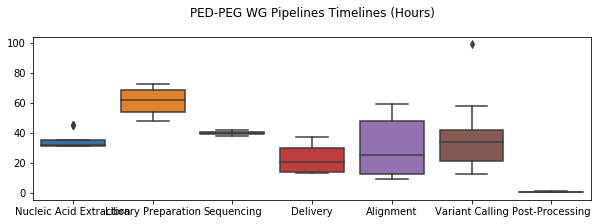

In [40]:
import seaborn as sns
plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=s_df)
_ = ax.set_title('PED-PEG WG Pipelines Timelines (Hours)', y=1.0, pad=20)

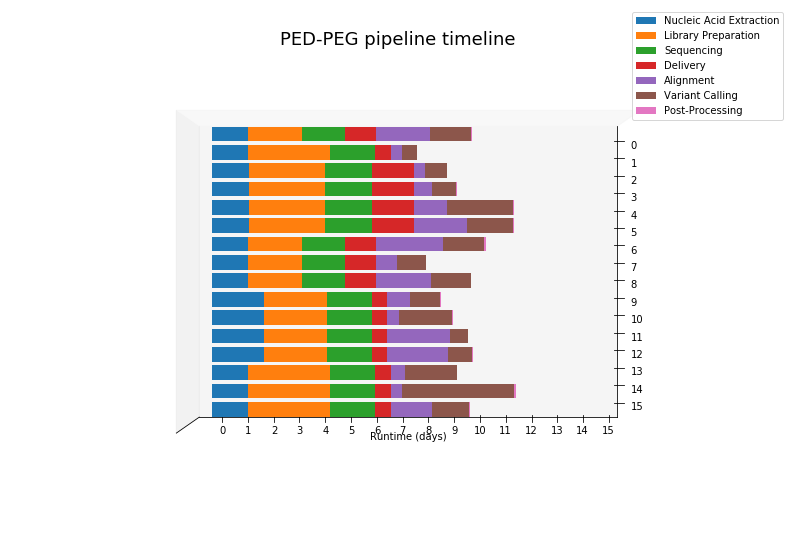

In [43]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig=plt.figure() 
ax=fig.add_subplot(111, projection='3d')
ax.view_init(90, 0)
    
ax = s_df.plot(kind="bar", figsize=(14, 10), stacked=True, ax=ax)
ax.set_xticklabels(s_df.index, rotation = 0, ha="left")
ax.set_ylabel("Runtime (days)")

_ = ax.set_title('PED-PEG pipeline timeline', fontsize=18)
_ = ax.set_yticks(np.arange(0, 24*16, 24))
_ = ax.set_yticklabels([f'{int(day)}' for day in np.arange(0, 24*16, 24) / 24])

ax.set_zticks([])

plt.show()

In [44]:
sti_df = s_df[[
    "Nucleic Acid Extraction", 
    "Library Preparation", 
    "Sequencing",
    "Delivery",
    "Alignment",
    "Variant Calling",
    "Post-Processing",
]]

sti_df

,Nucleic Acid Extraction,Library Preparation,Sequencing,Delivery,Alignment,Variant Calling,Post-Processing
0,31.15,48.00,38.17,27.37,47.87,36.25,0.6600
1,31.28,72.53,40.15,13.63,10.33,12.63,0.2320
2,32.20,67.32,41.62,37.42,9.27,19.25,0.3180
3,32.20,67.32,41.62,37.42,15.47,21.53,0.3100
4,32.20,67.32,41.62,37.42,29.09,57.96,1.0000
5,32.20,67.32,41.62,37.42,46.75,40.54,1.0640
6,31.15,48.00,38.17,27.37,59.15,36.77,1.1540
7,31.15,48.00,38.17,27.37,18.68,25.41,0.3020
8,31.15,48.00,38.17,27.37,49.03,34.88,0.3575
9,45.53,56.15,39.15,13.28,20.98,26.55,0.5420


In [45]:
median = sti_df.median()
std = sti_df.std()
min_range = sti_df.min()
max_range = sti_df.max()

xrange = [median - min_range, max_range - median]

median_start, median_end, steps = [], [], []
start, end, previous = 0, 0, 0
for step, value in median.iteritems():
    print((step, value))
    start += previous
    end += value
    median_start.append(start)
    median_end.append(end)
    steps.append(step)
    previous = value

median_end

('Nucleic Acid Extraction', 31.740000000000002)
('Library Preparation', 61.735)
('Sequencing', 39.65)
('Delivery', 20.5)
('Alignment', 25.035)
('Variant Calling', 33.82)
('Post-Processing', 0.394)


[31.740000000000002, 93.475, 133.125, 153.625, 178.66, 212.48, 212.874]

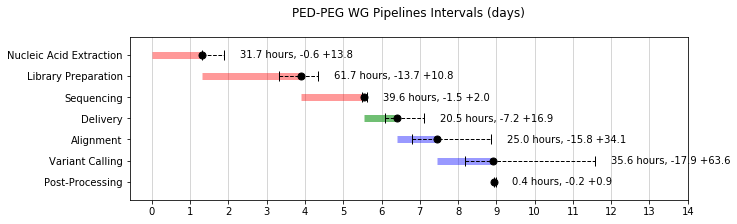

In [46]:
size = len(median)
colors = [(1,0,0, 0.4)] * 3 + [(76/255, 175/255, 80/255, 0.8)] * 1 +  [(0,0,1, 0.4)] * 3

figsize = (10, 3)
plt.figure(figsize=figsize)

err = plt.errorbar(median_end, np.arange(size)[::-1], xerr=[median, np.zeros(size)], ms=0, fmt='.k', ecolor=colors, lw=7, uplims=True, lolims=True)
err = plt.errorbar(median_end, np.arange(size)[::-1], xerr=xrange, ms=14, fmt='.k', lw=1, ecolor='black', capsize=5, capthick=1)
err[-1][0].set_linestyle('--')

ax = plt.gca()
_ = ax.set_title('PED-PEG WG Pipelines Intervals (days)', y=1.0, pad=20)
_ = plt.yticks(np.arange(size)[::-1], steps)
# _ = ax.xaxis.set_label_position('top') 
# _ = ax.xaxis.tick_top()

timerange = 24 * 7 * 2 + 1
_ = ax.set_xticks(np.arange(0, timerange , 24))
_ = ax.set_xticklabels([f'{int(day)}' for day in np.arange(0, timerange, 24) / 24])
_ = ax.grid(which='major', axis='x', linestyle='-', color="#CCCCCC")


# Divide by Teams
category = {0: "Wet Lab", 3: "IT", 4: "Bioinformatics"}
step_labels = []
for index, item in enumerate(median.iteritems()):
    step, value = item
    y_index = size - index - 1
    
    # Text next to durations
    mediand = round(median[index], 1)
    mind = round(xrange[0][index], 1)
    maxd = round(xrange[1][index], 1)
    textd = f'{mediand} hours, -{mind} +{maxd}'
    step_labels.append(f'{step} ({textd})')
    
    _ = ax.text(
        median_end[index] + xrange[1][index] + 10, 
        y_index,
        textd, 
        verticalalignment='center', 
        fontsize=10
    )

_ = ax.axhline(y= 0 - 0.5, linewidth=1, linestyle='-',color=(0,0,0,0))
_ = ax.axhline(y=size - 1 + 0.5, linewidth=1, linestyle='-',color=(0,0,0,0))

# _ = plt.yticks(np.arange(size)[::-1], step_labels)

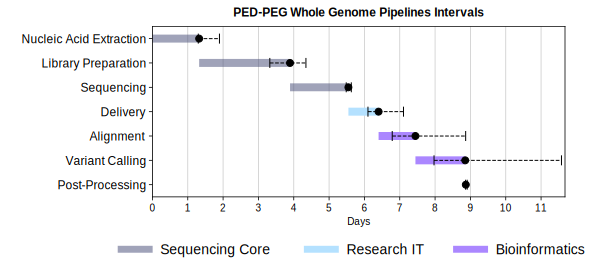

<Figure size 432x288 with 0 Axes>

In [48]:
from matplotlib.lines import Line2D

size = len(median)
colors = [(1,0,0, 0.4)] * 3 + [(76/255, 175/255, 80/255, 0.8)] * 1 +  [(0,0,1, 0.4)] * 3
colors = ["#95b2b0"]*0 + ["#42487480"]*3 + ["#b4e1ff"]*1 + ["#ab87ff"]*3 + ["#cbff4d"]*0
# ["e5beed","9593d9","7c90db","1c3041","f05d5e"]
# colors = ["424874","b4e1ff","ab87ff","fface4","c6ac8f"]

figsize = (8.25,4) # (10, 3.5)
plt.figure(figsize=figsize)

err = plt.errorbar(median_end, np.arange(size)[::-1], xerr=[median, np.zeros(size)], ms=0, fmt='.k', ecolor=colors, lw=8, uplims=True, lolims=True)
err = plt.errorbar(median_end, np.arange(size)[::-1], xerr=xrange, ms=14, fmt='.k', lw=1, ecolor='black', capsize=5, capthick=1)
err[-1][0].set_linestyle('--')

ax = plt.gca()
_ = ax.set_title('PED-PEG Whole Genome Pipelines Intervals', y=1.0, pad=10, fontweight='bold', fontsize=12)
_ = ax.set_xlabel('      Days')
_ = ax.yaxis.set_tick_params(labelsize='large')
_ = plt.yticks(np.arange(size)[::-1], steps)


timerange = 24 * 12
_ = ax.set_xticks(np.arange(0, timerange , 24))
_ = ax.set_xticklabels([f'{int(day)}' for day in np.arange(0, timerange, 24) / 24])
_ = ax.grid(which='major', axis='x', linestyle='-', color="#CCCCCC")

# Divide by Teams
categories = {0: "Sequencing Core", 3: "Research IT", 4: "Bioinformatics"}
step_labels = []
for index, item in enumerate(median.iteritems()):
    step, value = item
    y_index = size - index - 1
    
    # Text next to durations
    mediand = round(median[index], 1)
    mind = round(xrange[0][index], 1)
    maxd = round(xrange[1][index], 1)
    textd = f'{mediand} hours (-{mind}, {maxd})'
    step_labels.append(f'{step} ({textd})')
    
t_median_h = int(sum(median))
t_median_d = int(sum(median) / 24)
t_min_h = int(sum(xrange[0]))
t_min_d = int(sum(xrange[0]) / 24)
t_max_h = int(sum(xrange[1]))
t_max_d = int(sum(xrange[1]) / 24)

_ = ax.axhline(y= 0 - 1, linewidth=1, linestyle='-',color=(0,0,0,0))
_ = ax.axhline(y=size, linewidth=1, linestyle='-',color=(0,0,0,0))


max_x = (max(median_end) + xrange[1]['Variant Calling'])
ax.set_xlim([0, max_x + 2])
ax.set_ylim([-0.5, 6.5])

# Create Legend 
custom_lines = [
    Line2D([0], [0], color=color, lw=7)
    for color in list(dict.fromkeys(colors))
]
_ = plt.legend(custom_lines, categories.values(), loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=False, fontsize=14, ncol=3)


from io import BytesIO
from IPython.display import SVG, display

def display_svg(filename=None,font="Arial"):
    plt.rcParams['svg.fonttype'] = 'none'
    svg = BytesIO()
    plt.tight_layout()
    plt.savefig(svg, format="svg",bbox_inches = 'tight')
    if filename:
        plt.savefig(filename, format="svg",bbox_inches = 'tight')
    plt.close()
    svg.seek(0)
    display(SVG(svg.read().decode("utf-8").replace("font-family:DejaVu Sans",f"font-family:{font}")))

filename = "PedPegPilot-Figure"
display_svg(f"{filename}.svg")
plt.savefig(f"{filename}.pdf", bbox_inches='tight')
